In [1]:
import numpy as np
import pandas as pd
import random
import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns 
import yaml
from pathlib import Path

from util.functions import logistic
from structure_generation.path_connection_gen import ProceduralGraphGenerator, StatsUtils, GraphStructureGenerator




In [2]:
conf = yaml.safe_load(Path('config.yml').read_text())['reachability']

In [3]:
geometric_graph_conf = conf

In [4]:
geometric_graph_conf

{'num_simulation_runs': 20,
 'mean_degrees': [2, 5, 10, 15, 20],
 'nodes': 100,
 'structure_names': ['random_geometric', 'barabasi_albert']}

In [5]:
import multiprocessing, itertools

In [11]:
def run_simulation(modality : str, structure_num : int):
    results_dict_list = []
    for degree in geometric_graph_conf['mean_degrees']:
        results_dict = {
            "timesteps_saturation" : [],
            "fraction_infected_list" : [],
            "info_dict" : []
        }
        print(f"simulation run for degree {degree}")
        for i, repeat in tqdm.tqdm(enumerate(range(conf['num_simulation_runs']))):
            graphgen = GraphStructureGenerator(
                structure_name=geometric_graph_conf['structure_names'][structure_num], 
                num_nodes=int(geometric_graph_conf['nodes']), 
                target_mean_degree = degree
            )
            graph = graphgen.initial_adj_matrix
            graph_rand = graphgen.get_graph_structure().initial_adj_matrix

            x = ProceduralGraphGenerator(graph)
            infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
                modality=modality, verbose= False
            )

            results_dict["timesteps_saturation"].append(timesteps_saturation)
            results_dict["fraction_infected_list"].append(fraction_infected_list)
            results_dict["info_dict"].append(info_dict)
        
        results_dict_list.append(results_dict)
    return results_dict_list
    
def clean_results(results_dict_list : list):
    import itertools
    for result in tqdm.tqdm(results_dict_list): 
        for key in result.keys():
            if key == "fraction_infected_list":
                # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
                padded_list = np.array(
                    list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
                )
                result[key] = padded_list
                #result[key] = np.mean(padded_list, axis=0)
            if key == "info_dict":
                info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
                for key in info_dict_temp.keys():
                    if key == "modality":
                        info_dict_temp[key] = result['info_dict'][0]['modality']
                    else:
                        info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
                result['info_dict'] = info_dict_temp
            
        result['average_timesteps'] = np.average(result['timesteps_saturation'])
    return results_dict_list   

def plot_results(results_dict_list):
    for i, result in enumerate(results_dict_list): 
        print(result['info_dict'])
        for iter in result['fraction_infected_list']:
            timesteps_list = [x for x in range(len(iter))]
            try:
                p, cov = curve_fit(logistic, timesteps_list, iter)
                logistic_curve_data = logistic(timesteps_list, *p)
            except:
                pass
            plt.plot(timesteps_list, iter, )#label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
        #plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
        plt.title(f"saturation curve for {geometric_graph_conf['structure_name']} modality: {result['info_dict']['modality']} mean degree: {round(result['info_dict']['average_degree'], 2)}")
        plt.legend()
        plt.show()

REVERSABLE GEOMETRIC GRAPH SIMULATION

In [16]:
results_dict_list_geometric_reversable = run_simulation("reversable", 0)

[2, 5, 10, 15, 20]
simulation run for degree 2


20it [00:08,  2.29it/s]


simulation run for degree 5


20it [00:27,  1.36s/it]


simulation run for degree 10


20it [00:34,  1.74s/it]


simulation run for degree 15


20it [00:14,  1.41it/s]


simulation run for degree 20


20it [00:14,  1.36it/s]


In [17]:
cleaned_results_dict_list_geometric_reversabble = clean_results(results_dict_list_geometric_reversable)

100%|██████████| 5/5 [00:00<00:00, 450.07it/s]


{'average_degree': 3.058516094357769, 'num_nodes': 17.1, 'modality': 'reversable', 'clustering_coefficient': 0.49074515047646494, 'degree_assortivity': 0.17330836405338462, 'mean_shortest_pathlength': 3.5493015605206937}


KeyError: 'structure_name'

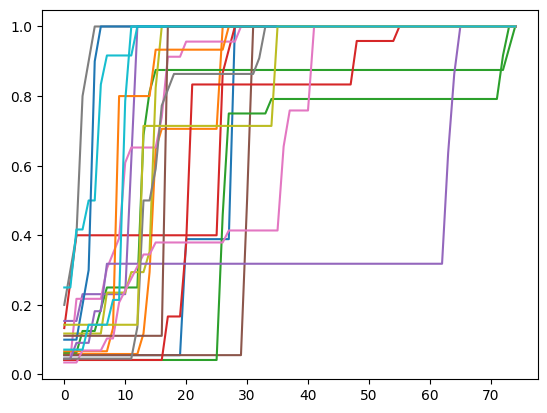

In [18]:
plot_results(cleaned_results_dict_list_geometric_reversabble)

IRREVERSABLE GEOMETRIC GRAPH SIMULATION

In [ ]:
results_dict_list_geometric_reversable = run_simulation("irreversable", 0)

In [ ]:
cleaned_results_dict_list_geometric_reversabble = clean_results(results_dict_list_geometric_reversable)

In [ ]:
plot_results(cleaned_results_dict_list_geometric_reversabble)

In [ ]:
import itertools
for result in tqdm.tqdm(results_dict_list): 
    for key in result.keys():
        if key == "fraction_infected_list":
            # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
            padded_list = np.array(
                list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
            )
            result[key] = padded_list
            #result[key] = np.mean(padded_list, axis=0)
        if key == "info_dict":
            info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
            for key in info_dict_temp.keys():
                if key == "modality":
                    info_dict_temp[key] = result['info_dict'][0]['modality']
                else:
                    info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
            result['info_dict'] = info_dict_temp
        
    result['average_timesteps'] = np.average(result['timesteps_saturation'])

In [ ]:
result['info_dict']

In [ ]:
for i, result in enumerate(results_dict_list): 
    print(result['info_dict'])
    for iter in result['fraction_infected_list']:
        timesteps_list = [x for x in range(len(iter))]
        try:
            p, cov = curve_fit(logistic, timesteps_list, iter)
            logistic_curve_data = logistic(timesteps_list, *p)
        except:
            pass
        plt.plot(timesteps_list, iter, )#label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    #plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    plt.title(f"saturation curve for {geometric_graph_conf['structure_name']} modality: {result['info_dict']['modality']} mean degree: {round(result['info_dict']['average_degree'], 2)}")
    plt.legend()
    plt.show()

In [ ]:
results_dict_list = []
modality = "irreversable"
for graph_rad in geometric_graph_conf['graph_edge_radii']:
    results_dict = {
        "timesteps_saturation" : [],
        "fraction_infected_list" : [],
        "info_dict" : []
    }
    print(f"simulation run for graph radius {graph_rad}")
    mean_degree_simulation_runs = []
    for i, repeat in tqdm.tqdm(enumerate(range(conf['num_simulation_runs']))):
        graphgen = GraphStructureGenerator(
            structure_name=geometric_graph_conf['structure_name'], 
            num_nodes=int(geometric_graph_conf['nodes']), 
            graph_edge_radius = float(graph_rad)
        )
        graph = graphgen.initial_adj_matrix
        graph_rand = graphgen.get_graph_structure().initial_adj_matrix

        x = ProceduralGraphGenerator(graph)
        infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
            modality=modality, verbose= False
        )

        results_dict["timesteps_saturation"].append(timesteps_saturation)
        results_dict["fraction_infected_list"].append(fraction_infected_list)
        results_dict["info_dict"].append(info_dict)
    
    results_dict_list.append(results_dict)

In [ ]:
import itertools
for result in tqdm.tqdm(results_dict_list): 
    for key in result.keys():
        if key == "fraction_infected_list":
            # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
            padded_list = np.array(
                list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
            )
            result[key] = padded_list
            #result[key] = np.mean(padded_list, axis=0)
        if key == "info_dict":
            info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
            for key in info_dict_temp.keys():
                if key == "modality":
                    info_dict_temp[key] = result['info_dict'][0]['modality']
                else:
                    info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
            result['info_dict'] = info_dict_temp
        
    result['average_timesteps'] = np.average(result['timesteps_saturation'])

In [ ]:
for i, result in enumerate(results_dict_list): 
    print(result['info_dict'])
    for iter in result['fraction_infected_list']:
        timesteps_list = [x for x in range(len(iter))]
        try:
            p, cov = curve_fit(logistic, timesteps_list, iter)
            logistic_curve_data = logistic(timesteps_list, *p)
        except:
            pass
        plt.plot(timesteps_list, iter, )#label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    #plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    plt.title(f"saturation curve for {geometric_graph_conf['structure_name']} modality: {result['info_dict']['modality']} mean degree: {round(result['info_dict']['average_degree'], 2)}")
    plt.legend()
    plt.show()

In [ ]:
albert_graph_config = conf['barabasi_albert']
albert_graph_config

In [ ]:
results_dict_list = []
modality = "reversable"
for node_degree in albert_graph_config['node_degree']:
    results_dict = {
        "timesteps_saturation" : [],
        "fraction_infected_list" : [],
        "info_dict" : []
    }
    print(f"simulation run for graph degree {node_degree}")
    mean_degree_simulation_runs = []
    for i, repeat in tqdm.tqdm(enumerate(range(conf['num_simulation_runs']))):
        graphgen = GraphStructureGenerator(
            structure_name=albert_graph_config['structure_name'], 
            num_nodes=int(albert_graph_config['nodes']), 
            node_degree = int(node_degree)
        )
        graph = graphgen.initial_adj_matrix
        graph_rand = graphgen.get_graph_structure().initial_adj_matrix

        x = ProceduralGraphGenerator(graph)
        infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
            modality=modality, verbose= False
        )

        results_dict["timesteps_saturation"].append(timesteps_saturation)
        results_dict["fraction_infected_list"].append(fraction_infected_list)
        results_dict["info_dict"].append(info_dict)
    
    results_dict_list.append(results_dict)

In [ ]:
import itertools
for result in tqdm.tqdm(results_dict_list): 
    for key in result.keys():
        if key == "fraction_infected_list":
            # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
            padded_list = np.array(
                list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
            )
            result[key] = padded_list
            #result[key] = np.mean(padded_list, axis=0)
        if key == "info_dict":
            info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
            for key in info_dict_temp.keys():
                if key == "modality":
                    info_dict_temp[key] = result['info_dict'][0]['modality']
                else:
                    info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
            result['info_dict'] = info_dict_temp
        
    result['average_timesteps'] = np.average(result['timesteps_saturation'])

In [ ]:
for i, result in enumerate(results_dict_list): 
    for iter in result['fraction_infected_list']:
        timesteps_list = [x for x in range(len(iter))]
        try:
            p, cov = curve_fit(logistic, timesteps_list, iter)
            logistic_curve_data = logistic(timesteps_list, *p)
        except:
            pass
        plt.plot(timesteps_list, iter, )#label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    #plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    plt.title(f"saturation curve for {albert_graph_config['structure_name']} modality: {result['info_dict']['modality']} mean degree: {round(result['info_dict']['average_degree'], 2)}")
    plt.legend()
    plt.show()

In [ ]:
results_dict_list = []
modality = "irreversable"
for node_degree in albert_graph_config['node_degree']:
    results_dict = {
        "timesteps_saturation" : [],
        "fraction_infected_list" : [],
        "info_dict" : []
    }
    print(f"simulation run for graph degree {node_degree}")
    mean_degree_simulation_runs = []
    for i, repeat in tqdm.tqdm(enumerate(range(conf['num_simulation_runs']))):
        graphgen = GraphStructureGenerator(
            structure_name=albert_graph_config['structure_name'], 
            num_nodes=int(albert_graph_config['nodes']), 
            node_degree = int(node_degree)
        )
        graph = graphgen.initial_adj_matrix
        graph_rand = graphgen.get_graph_structure().initial_adj_matrix

        x = ProceduralGraphGenerator(graph)
        infection_matrix_list, timesteps_saturation, fraction_infected_list, info_dict = x.infect_till_saturation(
            modality=modality, verbose= False
        )

        results_dict["timesteps_saturation"].append(timesteps_saturation)
        results_dict["fraction_infected_list"].append(fraction_infected_list)
        results_dict["info_dict"].append(info_dict)
    
    results_dict_list.append(results_dict)

In [ ]:
import itertools
for result in tqdm.tqdm(results_dict_list): 
    for key in result.keys():
        if key == "fraction_infected_list":
            # Pad the list to ones to the longest saturation length, find the mean across all simulations and the std at each timestep
            padded_list = np.array(
                list(zip(*itertools.zip_longest(*result[key], fillvalue=1)))
            )
            result[key] = np.mean(padded_list, axis=0)
        if key == "info_dict":
            info_dict_temp = {k : None for k in result['info_dict'][0].keys()}
            for key in info_dict_temp.keys():
                if key == "modality":
                    info_dict_temp[key] = result['info_dict'][0]['modality']
                else:
                    info_dict_temp[key] = np.average([x[key] for x in result['info_dict']])
            result['info_dict'] = info_dict_temp
        
    result['average_timesteps'] = np.average(result['timesteps_saturation'])

In [ ]:
for result in results_dict_list: 
    timesteps_list = [x for x in range(len(result['fraction_infected_list']))]

    p, cov = curve_fit(logistic, timesteps_list, result['fraction_infected_list'])
    logistic_curve_data = logistic(timesteps_list, *p)
    print("run statistics")
    print(result['info_dict'])
    plt.plot(timesteps_list, result['fraction_infected_list'], label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    plt.title(f"saturation curve for modality {result['info_dict']['modality']} mean degree {round(result['info_dict']['average_degree'], 2)}")
    plt.legend()
    plt.show()

In [ ]:
try: 
            #Fit a logistic curve to the simulated infection data for one simulation run, generate data with this logistic, use to find residuals in fit
            p, cov = curve_fit(logistic, timesteps, fraction_infected_list)
            logistic_curve_data = logistic(timesteps, *p)
            residuals_dict[graph_rad].extend(fraction_infected_list - logistic_curve_data)
            mean_degree_simulation_runs.append(average_degree)
        except RuntimeError as e:
            print(e)
            pass 
    average_degrees.append(np.mean(mean_degree_simulation_runs))

#Update keys of dictionary so that keys are the (averaged) mean degree of the simulations networks
residuals_dict = {k : v for k,v in list(zip(average_degrees, residuals_dict.values()))}
least_noisy_data = residuals_dict
for key in residuals_dict.keys(): 
    sns.kdeplot(residuals_dict[key], label=f"mean degree : {round(key, 2)}")
plt.legend()
plt.show()